In [15]:
%matplotlib inline

Using $L_0$ regularization in predicting genetic risk
====================================

The main aim of this document is to outline the code and theory of using the $L_0$ norm in a regularized regression with the objective to predict disease risk from genetic data.

This document contains my thought process and understanding of the implementation of $L_0$.
I will aim to integrate the code into existing tools so it can be easily used.
Ideally I will also compare the performance again $L_1$ as well as $L_2$ norm (aka Lasso and Ridge regression) in predicting simulated data.

## Literature used

I made use of the following papers:

- Learning Sparse Neural Networks through $L_0$ Regularization [link](http://arxiv.org/abs/1712.01312)
- The Variational Garrote [link](http://link.springer.com/10.1007/s10994-013-5427-7)

# Introduction

Let $\mathcal{D}$ the dataset consisting of $N$ input-output pairs $\{(x_1, y_1), \ldots, (x_N, y_N)\}$ and consider the regularized minimization procedure with $L_p$ regularization of the parameters $\omega$

$$
\mathcal{R}(\theta) = \frac{1}{N} ( \sum^N_{i=1} \mathcal{L}(h(x_i; \theta), y_i)) + \lambda ||\theta||_p
$$

with $\theta^* = arg \min_{\theta}\{\mathcal{R}(\theta)\}$.

While $L_1$ and $L_2$ are well defined the definition of $L_0$ varies.
Hence I will define it as:
$$
||\theta||_0 = \sum^{|\theta|}_{j=1} I[\theta_j \neq 0]
$$

Here it is important that, in contrast to $L_1$ and $L_2$, the $L_0$ norm does not shrink the parameters value but sets it wither to 0 or not 0.
This effect might be desirable in genetic data due to high correlations among SNPs.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [17]:
def l0(x):
    return(np.sum(x!=0))

def l1(x):
    return(np.sum(np.abs(x)))

def l2(x):
    return(np.sum(np.power(x, 2)))

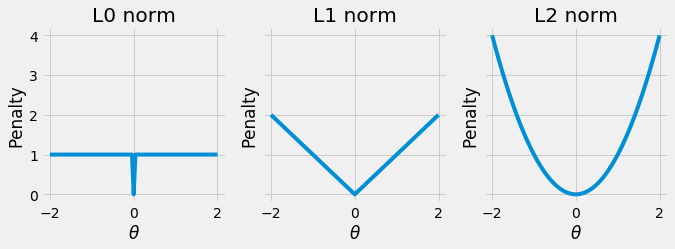

In [18]:
x = np.linspace(-2, 2, 50)
x = np.append(x, 0)
x = np.sort(x)

fig, (axs0, axs1, axs2) = plt.subplots(1, 3, sharex='all', sharey='all')
fig.set_size_inches((10, 3))

axs0.set_title('L0 norm')
axs1.set_title('L1 norm')
axs2.set_title('L2 norm')

[k.set_xlabel(r'$\theta$') for k in [axs0, axs1, axs2]]
[k.set_ylabel('Penalty') for k in [axs0, axs1, axs2]]

axs0.plot(x, [l0(k) for k in x])
axs1.plot(x, [l1(k) for k in x])
axs2.plot(x, [l2(k) for k in x])

The plot above demonstrates nicely the penalty for different norms.
As one can see both $p=1$ and $p=2$ allow shrinkage for large values of $\theta$, while $p=0$ the penalty is constant.

## Minimizing $L_0$ norm for parametric models

Optimization under the $L_0$ penalty is computational difficult due to the non-differentiability as well as the comninatorial nature of $2^{|\theta|}$ (the number of possible states of the $L_0$ penalty function).

Hence @Author relaxed the discrete nature of $L_0$ to allow for efficient computations.
Here I will outline their approach first in order to understand it better.

The first step is to reformulate the $L_0$ norm under the parameters $\theta$.
Hence let,
$$
\begin{matrix}
\theta_j = \tilde{\theta_j}z_j, & z_j \in \{0, 1\}, & \tilde{\theta}_j \neq 0, & ||\theta||_0 = \sum^{|\theta|}_{j=1} z_j
\end{matrix}
$$

Therefore $z_j$ can be considered as binary gates, and the $L_0$ norm can be seen as the amount of gates being turned on.
Then we can reformulate the minimization from Eq. 1 by letting $q(z_j|\pi_j) = Bern(\pi_j)$
$$
\mathcal{R}(\tilde{\theta}, \pi) = \mathbb{E}_{q(z|\pi)} [\frac{1}{N} ( \sum^N_{i=1} \mathcal{L}(h(x_i; \tilde{\theta} \otimes z), y_i)] + \lambda \sum^{|\theta|}_{j=1} \pi_j \\
\quad \textrm{with} \quad 
\theta^*, \pi^* = arg \min_{\tilde{\theta}, \pi} \{\mathcal{R}(\tilde{\theta}, \pi)\}
$$

Here we encounter the problem of non-differentiability of the left hand side of the previous equation size z is discrete (the penalty term is straight forward to minimize).
It seems there are methods to optimize this functions but they are supposed to suffer from high variance and biased gradients.
Therefore @Author used an alternative to smooth the objective function for efficient gradient based optimization.

Let $s$ be a continuous random variable with distribution $q(s)$ that has the parameter $\phi$ we can then let $z$ be given a hard sigmoid function:
$$
s \sim q(s|\phi) \\
z = min(1, max(0, s))
$$
This allows the gate to still be $0$ as well as the computation of the probability of non-zero parameters (number of active gates) with a simple cdf ($Q(\cdot)$ of s:
$$
q(z\neq 0 | \phi) = 1 - Q(s \leq 0 | \phi)
$$
Then we can reformulate the previous equation as
$$
\mathcal{R}(\tilde{\theta}, \phi) = \mathbb{E}_{q(s|\phi)} [\frac{1}{N} ( \sum^N_{i=1} \mathcal{L}(h(x_i; \tilde{\theta} \otimes g(s)), y_i)] + \lambda \sum^{|\theta|}_{j=1} (1 - Q(s_j \leq 0 | \phi_j)) \\
\quad \textrm{with} \quad 
\theta^*, \phi^* = arg \min_{\tilde{\theta}, \phi} \{\mathcal{R}(\tilde{\theta}, \phi)\},
\quad 
g(\cdot) = min(1, max(0, \cdot))
$$
However, it is still necessary to define the distribution for $s$.
Here it is suggested to use a hard concrete distribution.

### The hard concrete distribution

Lets assume that $s$ is a random variable distributed in the (0, 1) interval with probability density $q_s(s|\phi)$ and cdf $Q_s(s|\phi)$.
The parameters of the distribution are $\phi = (\log \alpha, \beta)$, where $\log\alpha$ is the mean and $\beta$ the temperature (???).
We can then stretch this distribution to the $(\gamma, \delta$) interval with $\gamma < 0$ and $\delta > 1$:
$$
u\sim U(0, 1), 
\quad
s = Sigmoid((\log u - \log(1 - u) + \log\alpha) / \beta), \quad
\bar{s} = s(\delta - \gamma) + \gamma, \quad
z = \min(1, \max(0, \bar{s})
$$

Since these formulas are a bit difficult to visualize I have plotted them below to gain a better understanding of that they are doing and how these functions behave.

In [19]:
def hard_sigmoid(x):
    return np.min([1, np.max([0, x])])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hard_concrete_dist(loc, temp, gamma, zeta):
    u = np.random.random()
    s = sigmoid((np.log(u) - np.log(1 - u) + np.log(loc)) / temp)
    shat = s*(zeta - gamma) + gamma
    return hard_sigmoid(shat)

def plot_hard_concreate(loc, temp, gamma, zeta, num=10000, bins=100, **kwargs):
    plt.hist([hard_concrete_dist(loc, temp, gamma, zeta) for _ in range(num)], bins=bins, density=True, **kwargs)

In [20]:
x = np.arange(-6, 6, 0.1)
y1 = sigmoid(x)
y2 = [hard_sigmoid(k) for k in x]

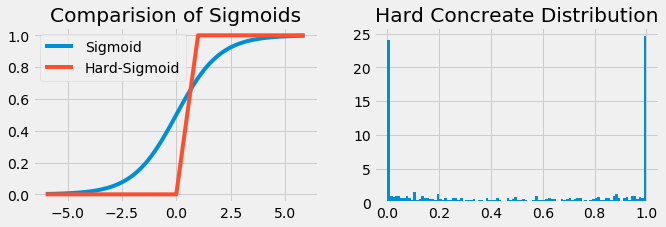

In [25]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((10, 3))
axs[0].set_title('Comparision of Sigmoids')
axs[1].set_title('Hard Concreate Distribution')

axs[0].plot(x, y1, label='Sigmoid')
axs[0].plot(x, y2, label='Hard-Sigmoid')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels)
values = [hard_concrete_dist(loc=1, temp=0.5, gamma=-0.1, zeta=1.1) for _ in range(1000)]
n, bins, patches = axs[1].hist(values, bins=100, density=True)
#fig.show()

# Implementation of the $L_0$ norm

The next step is to implement the theory into practice.
I will therefore make use of Google's tensorflow to implement the $L_0$ norm.
Here its good to know that this has been implemented before in PyTorch.
I will compare my and their implementation to assure I have done it correctly.
The reason why I am not directly using PyTorch is that I don't want to learn yet again another library.
Furthermore, implementing $L_0$ into tensorflow gives me hopefully a better understanding of the library itself as well as the $L_0$ norm.
In addition, tensorflow can compute the derivatives for me, so I don't have to take care of this.

The data I am going to use was simulated by Tim.
This includes non-linear effects, binary and continous phenotypes.
I will first compute only penalized linear models (that is $L_0$ to $L_2$ norm) with tensorflow and validate the results (of $L_1$ and $L_2$ with already implemented libraries (sklearn).
The main objective is to improve prediction accuracy.

In [32]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pyplink import PyPlink
import sys
import os

In [28]:
DATAFOLDER = os.path.realpath(filename='../data')
PLINKDATA = '1kgb'
FILEPATH = os.path.join(DATAFOLDER, PLINKDATA)

def count_lines(filepath, header=False):
    """Count the number of rows in a file"""
    with open(filepath, 'r') as f:
        count = sum(1 for line in f)
    if header:
        count -= 1
    return count

print('Number of subjects:', count_lines(os.path.join(FILEPATH, '.fam'), True))
print('Number of SNPs:', count_lines(os.path.join(FILEPATH, '.bim'), False))

In [29]:
def get_matrix(pfile, max_block):
    """Extract a genotype matrix from plink file."""
    with PyPlink(pfile) as bed:
        bim = bed.get_bim()
        fam = bed.get_fam()
        n = fam.shape[0]
        p = bim.shape[0]
        assert(max_block <= p)
        genotypemat = np.zeros((n, max_block), dtype=np.int64)
        u = 0
        for loci_name, genotypes in bed:
            genotypemat[:, u] = np.array(genotypes)
            u += 1
            if u >= max_block:
                break
        return genotypemat

In [30]:
# define size of training, validation and testing data
sample_fractions = (0.8, 0.15, 0.05)
assert sum(sample_fractions) == 1.0
training_size, validation_size, testing_size = sample_fractions
data_training, data_testing, label_training, label_testing = train_test_split(pheno, genotypemat, train_size=training_size)
data_validataion, data_testing, label_validation, label_testing = train_test_split(data_testing, label_testing, train_size=2/3)
print("Samples in training:", len(label_training))
print("Samples in validation:", len(label_validation))
print("Samples in testing:", len(label_testing))